In [1]:
## IMPORTS

# External modules
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import time
# Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error, mean_absolute_percentage_error


# Project modules
import filter

In [2]:
## FUNCTIONS


## DATAFRAME CREATION
def get_artworks_df():
    artworks = pd.read_csv('../temporary-files/saatchi_artworks_info.csv')
    artworks.rename(columns=lambda x: x.title(), inplace=True)
    artworks.rename(columns={'Price': 'Price (US$)', 'Size': 'Size (in²)'}, inplace=True)
    artworks = calculate_area_and_price_per_area(artworks)
    for column_name in ['Styles', 'Mediums', 'Subjects', 'Materials']:
        artworks[column_name] = artworks[column_name].apply(lambda x: [str(value.strip()) for value in x.split(',')])

    # Filter out non 'one-of-a-kind' artworks
    artworks = artworks[artworks['Original'] == 'One-of-a-kind Artwork']

    for column_name in ['Title']:
        artworks[column_name] = artworks[column_name].apply(lambda x: [str(value.strip()) for value in x.split(' ')])
    # Remove outliers (artworks with Price (US$/in²) in the 5% and 95% percentiles)
    artworks = artworks[artworks['Price (US$/in²)'] > artworks['Price (US$/in²)'].quantile(0.05)]
    artworks = artworks[artworks['Price (US$/in²)'] < artworks['Price (US$/in²)'].quantile(0.95)]
    return artworks


def calculate_area_and_price_per_area(dataframe):
    # Iterate over the "Size" column
    df = dataframe.copy()
    for i, size in enumerate(dataframe['Size (in²)']):
        # Extract the dimensions using regular expression
        dimensions = re.findall(r'\d+(?:\.\d+)?', size)
        if len(dimensions) >= 2:
            # Extract the width and height dimensions
            try:
                width = float(dimensions[0])
                height = float(dimensions[1])
                total_area = width * height
                df.at[i, 'Size (in²)'] = total_area
            except:
                df.at[i, 'Size (in²)'] = 'NaN'
    df['Price (US$/in²)'] = df['Price (US$)'] / df['Size (in²)']

    return df


def get_occurrence_count_on_col_dict(values):
    # Get all unique values from the column
    occurrences_counts_dict = dict(Counter(values))
    return occurrences_counts_dict


def create_segments_dataframe(segments_dfs):
    all_segments_df = pd.DataFrame(index=segments_dfs.keys(),
                                   columns=['Mean Price (US$)', 'Median Price (US$)', 'Mean Size (in²)','Median Size (in²)',
                                            'Mean Price (US$/in²)', 'Median Price (US$/in²)', 'Count'])
    for key, value in segments_dfs.items():
        all_segments_df.loc[key, 'Mean Price (US$)'] = value['Price (US$)'].mean().round(0)
        all_segments_df.loc[key, 'Median Price (US$)'] = value['Price (US$)'].median().round(0)
        all_segments_df.loc[key, 'Mean Size (in²)'] = value['Size (in²)'].mean().round(0)
        all_segments_df.loc[key, 'Median Size (in²)'] = value['Size (in²)'].median().round(0)
        all_segments_df.loc[key, 'Mean Price (US$/in²)'] = value['Price (US$/in²)'].mean().round(2)
        all_segments_df.loc[key, 'Median Price (US$/in²)'] = value['Price (US$/in²)'].median().round(2)
        all_segments_df.loc[key, 'Count'] = len(value)
    all_segments_df.sort_values(by='Mean Price (US$)', ascending=False, inplace=True)
    return all_segments_df


def group_by_segments(artworks_data, column_name, column, occurrences_threshold):

    segments_dfs = get_dfs_for_segments(filtered_artworks_data, column_name, occurrence_count_on_col_dict, occurrences_threshold)

    create_segments_dataframe(segments_dfs)
    
    # New dataframe for each segment
    segments_dfs = {}
    for key, value in occurrence_count_on_col_dict.items():
        if value > occurrences_threshold:
            segments_dfs[key] = dataframe[dataframe[column_name].apply(lambda x: key in x)]
    return segments_dfs



def analyse_by_column(dataframe, column_name, threshold):
    artworks_count_by_segment = dataframe[column_name].value_counts()
    artworks_count_pct_by_segment = artworks_count_by_segment / dataframe[column_name].value_counts().sum()
    selection = artworks_count_by_segment[artworks_count_by_segment > threshold].index
    dataframe = dataframe[dataframe[column_name].isin(selection)]
    return dataframe

def compare_segments(dataframe, segments_to_compare, x_column_name, y_column_name):
    for segment in segments_to_compare:
        print(segment)

        if segment == 'All':
            segment_df = dataframe
        else:
            segment_df = segments_dfs[segment]

        x = segment_df[[x_column_name]]
        y = segment_df[y_column_name]
        print('stats:', get_stats(segment_df, x, y))
        get_all_models(x, y)

        xlim = (0, 10000)
        ylim = (0, 40000)


def segment_and_clean_data(artworks_data, column_name, occurrences_threshold):
    column = artworks_data[column_name]
    
    segments_in_column_list = [value for sublist in column for value in sublist]
    occurrence_count_on_col_dict = get_occurrence_count_on_col_dict(segments_in_column_list)
    
    filtered_artworks_data = remove_empty_rows(artworks_data, column)
    filtered_artworks_data = filtered_artworks_data.dropna(subset=['Price (US$)', 'Size (in²)'])
    filtered_artworks_data[column_name] = column
    
    segments_dfs = get_dataframes_for_segments(filtered_artworks_data, column_name, occurrence_count_on_col_dict, occurrences_threshold)
    all_segments_df = create_segments_dataframe(segments_dfs)
    
    return filtered_artworks_data, all_segments_df, segments_dfs


def remove_empty_rows(dataframe, column):
    return dataframe[column.apply(lambda x: len(x) > 0)]


def get_dataframes_for_segments(dataframe, column_name, occurrence_count_on_col_dict, occurrences_threshold):
    segments_dfs = {}
    for key, value in occurrence_count_on_col_dict.items():
        if value > occurrences_threshold:
            segments_dfs[key] = dataframe[dataframe[column_name].apply(lambda x: key in x)]
    return segments_dfs



def prepare_dataframe_dummies(artworks_data, column_name, segments_dfs):
    dummies_for_segment = artworks_data[['Price (US$)', column_name]].dropna(subset=['Price (US$)'])
    
    for key, value in segments_dfs.items():
        dummies_for_segment[key] = artworks_data[column_name].apply(lambda x: True if key in x else False)
    
    return dummies_for_segment


def get_dummies_for_all_segments(artworks):
    dummies_for_all_segments = pd.DataFrame()

    # get one df with dummies for styles, mediums, materials and subjects
    for column_name in ['Styles', 'Mediums', 'Materials', 'Subjects']:
        column = artworks[column_name]
        occurrences_threshold = 200
        filtered_artworks_data, all_segments_df, segments_dfs = segment_and_clean_data(artworks, column_name, occurrences_threshold)
        dummies_for_segment = prepare_dataframe_dummies(artworks, column_name, segments_dfs).drop(columns=['Price (US$)'])
        # concat dummies_for_segment to dummies_for_all_segments
        dummies_for_all_segments = pd.concat([dummies_for_all_segments, dummies_for_segment], axis=1)


    dummies_for_all_segments.drop(columns=['Styles', 'Mediums', 'Materials', 'Subjects'], inplace=True)

    # add price, size, country
    columns_to_add = ['Size (in²)', 'Price (US$)', 'Price (US$/in²)', 'Country', 'Favorite', 'Url', 'Title', 'Artist Produced Limited Edition Of', 'Original Created']
    for column_name in columns_to_add:
        dummies_for_all_segments[column_name] = artworks[column_name]

    return dummies_for_all_segments


def analyse_by_segments(artworks, column_name, sortby, min_frequency):
    artworks_by_segment = analyse_by_column(artworks, column_name1, min_frequency1)
    # Get mean price per segment as 'Mean Price' column
    mean_price_by_segment = artworks_by_segment.groupby(column_name1).agg({'Price (US$)': 'mean'})
    median_price_by_segment = artworks_by_segment.groupby(column_name1).agg({'Price (US$)': 'median'})
    mean_price_per_in_by_segment = artworks_by_segment.groupby(column_name1).agg({'Price (US$/in²)': 'mean'})
    median_price_per_in_by_segment = artworks_by_segment.groupby(column_name1).agg({'Price (US$/in²)': 'median'})
    col_analysis_by_segment = pd.concat([mean_price_by_segment, median_price_by_segment, mean_price_per_in_by_segment, median_price_per_in_by_segment, artworks[column_name1].value_counts()], axis=1)
    col_analysis_by_segment.columns = ['Mean Price (US$)', 'Median Price (US$)','Mean Price (US$/in²)', 'Median Price (US$/in²)', 'Count']
    # filter out segments with less than [min_frequency] artworks
    col_analysis_by_segment = col_analysis_by_segment[col_analysis_by_segment['Count'] > min_frequency1]

    col_analysis_by_segment.sort_values(by=sort_by1, ascending=False, inplace=True)
    col_analysis_by_segment = col_analysis_by_segment.dropna()

    return col_analysis_by_segment

In [3]:
## MODELS


def get_stats(x, y):
    stats = {}
    for variable in [x, y]:
        max_variable = round(max(variable), 2)
        min_variable = round(min(variable), 2)
        mean_variable = round(variable.mean(), 2)
        median_variable = round(variable.median(), 2)
        stats_variable = {'Max': max_variable, 'Min': min_variable, 'Mean': mean_variable, 'Median': median_variable}
        # add stats_variable to stats
        stats[variable] = stats_variable
    return stats


## GET MODELS

def get_decision_tree(X_train, y_train):
    decision_tree = DecisionTreeRegressor(random_state=42)
    decision_tree.fit(X_train, y_train)
    return decision_tree

def get_linear_regression(X_train, y_train):
    linear_regression = LinearRegression()
    linear_regression.fit(X_train, y_train)
    return linear_regression

def get_random_forest(X_train, y_train):
    rf_model = RandomForestRegressor(random_state=1)
    rf_model.fit(X_train, y_train)
    return rf_model

def get_gradient_boosting(X_train, y_train):
    # get gradient boosting model
    gb_model = GradientBoostingRegressor(random_state=1)
    gb_model.fit(X_train, y_train)
    return gb_model

# gives a dataframe taking models as columns and score as rows
def get_all_models(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1)

    models = {'Linear regression': get_linear_regression(x_train, y_train),
              'Decision tree': get_decision_tree(x_train, y_train),
              'Random forest': get_random_forest(x_train, y_train),
              'Gradient boosting': get_gradient_boosting(x_train, y_train)}
    
    models_df = pd.DataFrame(columns=models.keys())
    for model_name, model in models.items():
        y_pred = model.predict(x_test)
        r2 = r2_score(y_test, y_pred)
        n = len(y_test)
        p = x_test.shape[1]
        adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        mean_error = mean_absolute_error(y_test, y_pred)
        median_error = median_absolute_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        pearson = np.corrcoef(y_test.to_numpy(), y_pred)[0, 1]

        models_df.loc['Pearson Correl Predicted-Actual', model_name] = pearson
        models_df.loc['R² Score', model_name] = r2
        models_df.loc['Adjusted R² Score', model_name] = adj_r2
        models_df.loc['Mean Absolute Error', model_name] = mean_error
        models_df.loc['Median Absolute Error', model_name] = median_error
        models_df.loc['Mean Absolute Percentage Error', model_name] = mape
        models_df.loc['Mean Squared Error', model_name] = mse

        # Round values
        models_df = models_df.round(2)

    return models_df, models

In [4]:
## CHARTS

dark_green_color_code = '#195921'
gold_color_code = '#FFD700'
black_color_code = '#000000'
salmon_color_code = '#FA8072'

def plot_segment_chart(dataframe, segments_column_name, bar_column_name, line_columns_names, title):
    bar_color_code = dark_green_color_code
    line_colors_codes = [gold_color_code, black_color_code]
    
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()
    ax1.bar(dataframe.index, dataframe[bar_column_name], color=bar_color_code)
    for line_column_name in line_columns_names:
        ax2.plot(dataframe.index, dataframe[line_column_name], label=line_column_name, color=line_colors_codes.pop(0))
    ax2.legend()
    ax1.set_xticklabels(dataframe.index, rotation=90)
    ax1.set_ylabel(bar_column_name)
    ax2.set_ylabel(str(line_columns_names))
    ax1.set_xlabel(segments_column_name)
    ax1.set_title(title)
    # beautify and enhance readability of the chart
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    ax1.tick_params(axis='x', which='major', labelsize=8)
    ax1.tick_params(axis='y', which='major', labelsize=8)
    ax2.tick_params(axis='y', which='major', labelsize=8)

    plt.show()


# SCATTER PLOT: SIZE VS PRICE
def plot_scatter(dataframe, x_column_name, y_columnname, title):
    plt.scatter(x=dataframe[x_column_name], y=dataframe[y_columnname], c=dark_green_color_code)
    plt.title(title)
    plt.xlabel(x_column_name)
    plt.ylabel(y_columnname)
    # improve readability of the chart
    plt.tick_params(axis='x', which='major', labelsize=8)
    plt.tick_params(axis='y', which='major', labelsize=8)
    # set color of scatter points as dark green
    
    plt.show()

In [5]:
artworks = get_artworks_df()
# artworks = artworks[['Styles', 'Mediums', 'Subjects', 'Artist', 'Size', 'Price']]
artworks.columns

Index(['Title', 'Packaging', 'Collage', 'Multi-Paneled Collage', 'Mediums',
       'Ready To Hang', 'Original', 'Digital', 'Country',
       'Multi-Paneled Mixed Media', 'Number Of Pieces', 'Artist_Link',
       'Styles', 'Subjects', 'Multi-Paneled Printmaking', 'Mixed Media',
       'Multi-Paneled Painting', 'Handling', 'Installation', 'Delivery Time',
       'Number Of Panels', 'Sale_Status', 'Materials', 'Photography', 'Url',
       'Artist Produced Limited Edition Of', 'Img', 'Ships From', 'Artist',
       'Multi-Paneled Sculpture', 'Favorite', 'Multi-Paneled Installation',
       'Original Created', 'Price (US$)', 'Sculpture',
       'Multi-Paneled Photography', 'Customs', 'Views', 'Description', 'Frame',
       'Printmaking', 'Multi-Paneled Drawing', 'Painting', 'Drawing',
       'Size (in²)', 'Price (US$/in²)'],
      dtype='object')

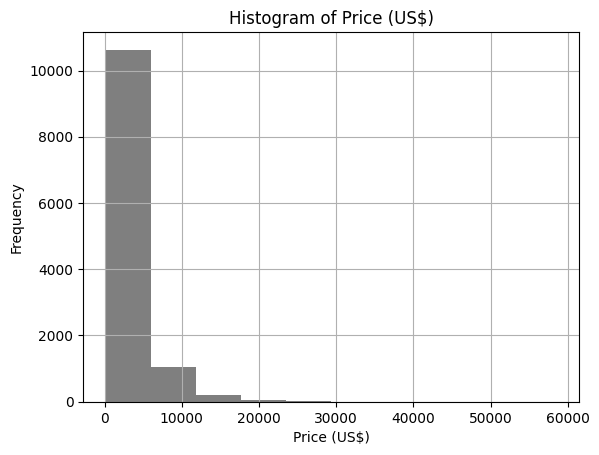

,max,min,mean,median,stdev,var
0,58550.0,135.0,2851.58432,1721.0,3428.282171,1.175312e+07


In [6]:
## DESCRITIVE ANALYSIS OF COLUMN

column = artworks['Price (US$)']

descritive_df = pd.DataFrame()
descritive_df.loc[0, 'max'] = column.max()
descritive_df.loc[0, 'min'] = column.min()
descritive_df.loc[0, 'mean'] = column.mean()
descritive_df.loc[0, 'median'] = column.median()
descritive_df.loc[0, 'stdev'] = column.std()
descritive_df.loc[0, 'var'] = column.var()

column.hist(color='black', alpha=0.5)
plt.title('Histogram of '+column.name)
plt.xlabel(column.name)
plt.ylabel('Frequency')
plt.show()


descritive_df

In [7]:
## ARTWORKS BY SEGMENT
column_name1 = 'Country'
sort_by1 = 'Count'
min_frequency1 = artworks.shape[0] * 0.01

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Dell\AppData\Local\Temp\ipykernel_14936\1083606402.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(dataframe.index, rotation=90)


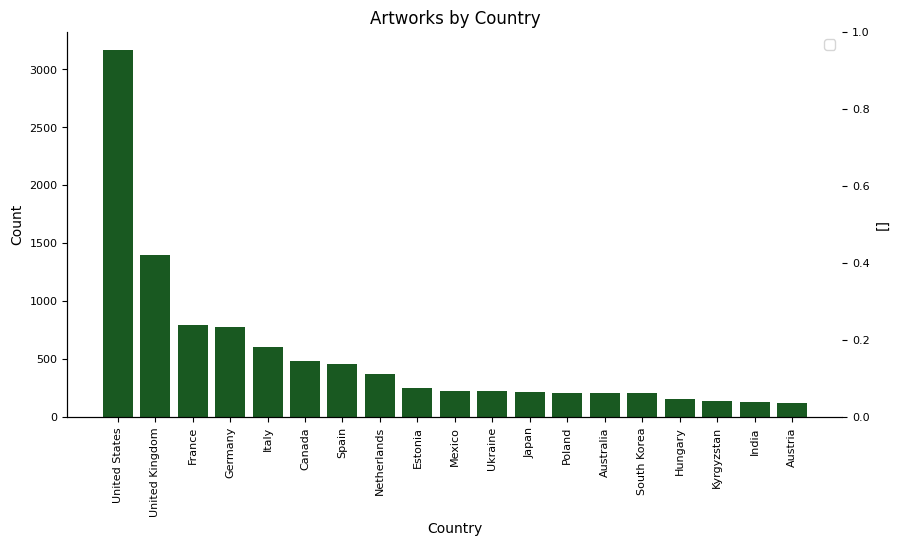

,Mean Price (US$),Median Price (US$),Mean Price (US$/in²),Median Price (US$/in²),Count
Country,,,,,
United States,2884.773000,1500.0,2.872959,2.413127,3163
United Kingdom,2476.196862,1582.5,3.503222,2.892039,1402
France,2279.108040,1500.0,2.629357,2.325492,796
Germany,4529.867609,3070.0,2.832167,2.232329,778
Italy,2579.246689,1895.0,3.346735,2.675585,604
Canada,2640.272917,1805.0,2.392322,1.976374,480
Spain,2619.427948,1600.0,2.915871,2.375995,458
Netherlands,3244.123989,2720.0,2.70312,2.177499,371
Estonia,5136.431452,4070.0,3.984395,3.834694,248


In [8]:
## ARTWORKS BY SEGMENT

col_analysis_by_segment = analyse_by_segments(artworks, column_name1, sort_by1, min_frequency1)

plot_segment_chart(col_analysis_by_segment, column_name1, 'Count', [], 'Artworks by ' + column_name1)
col_analysis_by_segment

In [9]:
## MODEL FOR SIZE

size_x = artworks[['Size (in²)']]
y = artworks['Price (US$)']

get_all_models(size_x, y)[0]

,Linear regression,Decision tree,Random forest,Gradient boosting
Pearson Correl Predicted-Actual,0.76682,0.730919,0.761335,0.782786
R² Score,0.586808,0.511749,0.574501,0.61265
Adjusted R² Score,0.58667,0.511586,0.574359,0.612521
Mean Absolute Error,1249.062655,1225.653147,1192.104353,1203.711335
Median Absolute Error,673.491157,587.95288,583.332725,655.760439
Mean Absolute Percentage Error,0.680983,0.56141,0.550329,0.59034
Mean Squared Error,4847660.67904,5728270.050108,4992050.956775,4544479.998509


In [22]:
## CHOOSE COLUMN TO EXPLORE
artworks_data = get_artworks_df()

column = artworks_data.Subjects
occurrences_threshold = artworks_data.shape[0]/100
sort_by = 'Median Price (US$/in²)'

C:\Users\Dell\AppData\Local\Temp\ipykernel_14936\1083606402.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(dataframe.index, rotation=90)


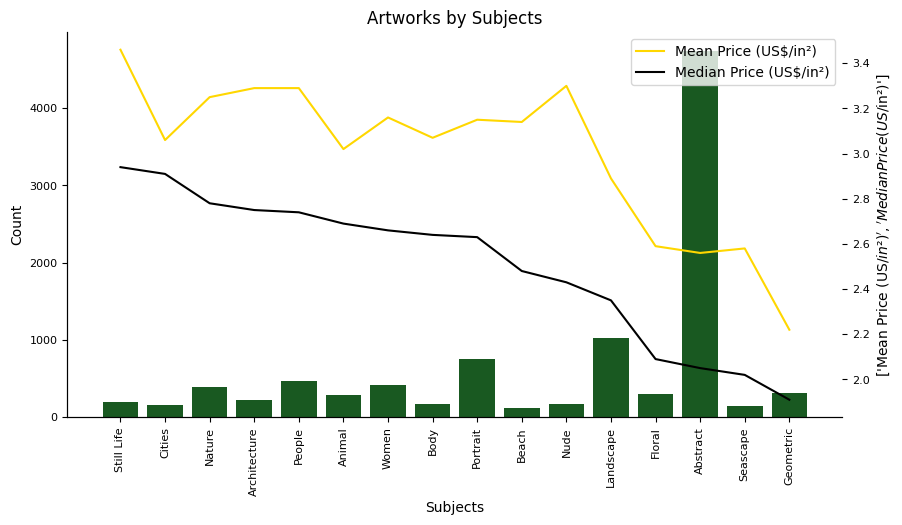

,Mean Price (US$),Median Price (US$),Mean Size (in²),Median Size (in²),Mean Price (US$/in²),Median Price (US$/in²),Count
Still Life,1843.0,995.0,648.0,432.0,3.46,2.94,203
Cities,2334.0,1610.0,978.0,720.0,3.06,2.91,152
Nature,3073.0,2210.0,1205.0,900.0,3.25,2.78,385
Architecture,2418.0,1150.0,917.0,464.0,3.29,2.75,222
People,2996.0,1850.0,1120.0,743.0,3.29,2.74,464
Animal,2004.0,1140.0,765.0,504.0,3.02,2.69,287
Women,2494.0,1560.0,975.0,743.0,3.16,2.66,412
Body,3079.0,1980.0,1218.0,762.0,3.07,2.64,171
Portrait,2533.0,1510.0,943.0,660.0,3.15,2.63,753
Beach,2446.0,1970.0,1007.0,870.0,3.14,2.48,122


In [23]:
## ANALYSE SEGMENTS

# TEMAS: E SE TIRAR ARTE ABSTRATA?

column_name = column.name
filtered_artworks_data, all_segments_df, segments_dfs = segment_and_clean_data(artworks_data, column_name, occurrences_threshold)
dummies_for_segment = prepare_dataframe_dummies(artworks_data, column_name, segments_dfs)

# get all models to dummies_for_segment
x = dummies_for_segment.drop(['Price (US$)', column_name], axis=1)
y = dummies_for_segment['Price (US$)']
segment_models_df, segment_models = get_all_models(x, y)

all_segments_df.sort_values(by=sort_by, ascending=False, inplace=True)

plot_segment_chart(all_segments_df, column_name, 'Count', ['Mean Price (US$/in²)', 'Median Price (US$/in²)'], 'Artworks by ' + column_name)
all_segments_df

In [25]:
## MODEL FOR SIZE, STYLES, MEDIUMS, MATERIALS AND SUBJECTS

# artworks = artworks[artworks['Price (US$/in²)'] > ]

# get artworks with price per in² in the top 25% of the dataset
artworks = artworks[artworks['Price (US$/in²)'] > artworks['Price (US$/in²)'].quantile(0.75)]

dummies_for_all_segments = get_dummies_for_all_segments(artworks)

# apply models to dummies_for_all_segments
x = dummies_for_all_segments.drop(columns=['Price (US$)', 'Price (US$/in²)', 'Country', 'Favorite', 'Url', 'Title', 'Artist Produced Limited Edition Of', 'Original Created'])
y = dummies_for_all_segments['Price (US$)']

models_output = get_all_models(x.values, y)
models_df = models_output[0]
models = models_output[1]
models_df

,Linear regression,Decision tree,Random forest,Gradient boosting
Pearson Correl Predicted-Actual,0.957319,0.94646,0.962988,0.961197
R² Score,0.916008,0.892468,0.927278,0.923872
Adjusted R² Score,0.912867,0.888447,0.924559,0.921026
Mean Absolute Error,722.284538,706.578571,577.302942,624.568882
Median Absolute Error,368.8752,200.0,213.045,266.909473
Mean Absolute Percentage Error,0.32489,0.198924,0.165919,0.207111
Mean Squared Error,1735335.824413,2221685.801368,1502487.02808,1572852.8255


In [13]:
## MODELS FOR SEGMENT

segment_models_df

,Linear regression,Decision tree,Random forest,Gradient boosting
Pearson Correl Predicted-Actual,0.27902,0.321279,0.336332,0.327213
R² Score,0.077825,0.090747,0.107948,0.106536
Adjusted R² Score,0.071317,0.084331,0.101653,0.100232
Mean Absolute Error,2062.933967,1994.309283,1984.434538,2015.297812
Median Absolute Error,1560.255996,1418.703927,1419.463239,1473.984646
Mean Absolute Percentage Error,1.869541,1.729044,1.732201,1.803939
Mean Squared Error,10819170.931658,10667562.527598,10465761.701261,10482316.011225


In [14]:
# CORRELATION MATRIX BETWEEN DUMMIES

data = dummies_for_all_segments.drop(columns=['Price (US$)', 'Price (US$/in²)', 'Country', 'Favorite', 'Url', 'Title', 'Artist Produced Limited Edition Of', 'Original Created'])
correlation_matrix = data.corr()
correlation_matrix
# show only correlations above 0.5 but different than 1
correlation_matrix[(correlation_matrix > 0.5) & (correlation_matrix < 1)]
# show correlations between 0.5 and 1 (without duplicates)
correlation_matrix[(correlation_matrix > 0.5) & (correlation_matrix < 1)].stack().drop_duplicates()

Abstract  Abstract    0.635475
dtype: float64

In [15]:
## GET FEATURE IMPORTANCES

rf_model = models['Random forest']

feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                      index = x.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
Size (in²),0.711060
Oil,0.014766
Cubism,0.014756
Modern,0.013448
Photorealism,0.012961
Abstract Expressionism,0.012874
Fine Art,0.012216
Acrylic,0.012006
Figurative,0.010378
Minimalism,0.010191


C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


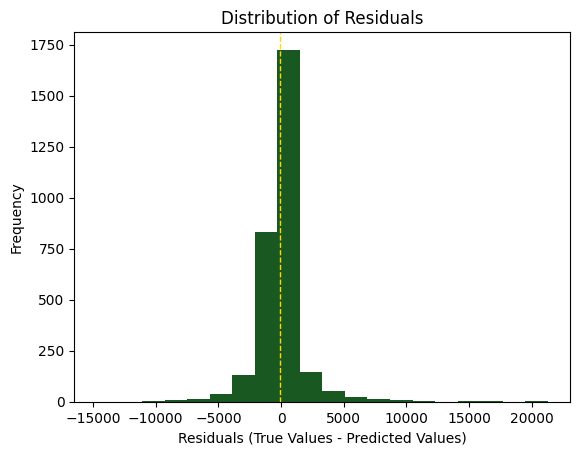

In [16]:
## DISTRIBUTION OF RESIDUALS

# get y_train and y_pred
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1)
y_pred = rf_model.predict(x_test)

residuals = y_test - y_pred

# Step 3: Visualize the distribution of residuals using a histogram
plt.hist(residuals, bins=20, color=dark_green_color_code)
# line of the mean
plt.axvline(residuals.mean(), color='gold', linestyle='dashed', linewidth=1)
plt.xlabel("Residuals (True Values - Predicted Values)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()


## distribuição por percentis

In [17]:
## QUANTILE LOSS

import numpy as np

def quantile_loss(y_true, y_pred, quantile):
    errors = y_true - y_pred
    return np.maximum(quantile * errors, (quantile - 1) * errors)

quantiles = [0.1, 0.5, 0.9]

for quantile in quantiles:
    loss = quantile_loss(y_test, y_pred, quantile)
    quantile_loss_value = np.mean(loss)
    print(f"Quantile Loss ({quantile}): {quantile_loss_value:.4f}")

Quantile Loss (0.1): 507.9317
Quantile Loss (0.5): 488.1623
Quantile Loss (0.9): 468.3928


In [18]:
## PLOT PRICE VS SIZE

## adicionar unidades
## log x log

plt.scatter(x=np.log(dummies_for_all_segments['Size'].astype(float)), y=np.log(dummies_for_all_segments['Price'].astype(float)), c=dark_green_color_code)
plt.title('Size vs Price')
plt.xlabel('Size (in²)')
plt.ylabel('Price (US$)')
# improve readability of the chart
plt.tick_params(axis='x', which='major', labelsize=8)
plt.tick_params(axis='y', which='major', labelsize=8)

KeyError: 'Size'

In [ ]:
## ESTUDOS DE CASO:
# QUADROS MAIS CAROS
# MAIORES RESÍDUOS

In [ ]:
## PLOT Y_TEST VS Y_PRED

# divide data into 3 percentils: 0-25%, 25-75%, 75-100%


# plot results of the random forest model (y_pred) vs actual data (y_test)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1)
rf_model = models['Random forest']
y_pred = rf_model.predict(x_test)
test_df = pd.DataFrame({'Actual Price (US$)': y_test, 'Predicted Price (US$)': y_pred})

## adicionar linha identidade e pegar a inclinação dela

## analisar todos os mais distantes da reta


plot_scatter(test_df, 'Actual Price (US$)', 'Predicted Price (US$)', 'Actual price vs predicted price')

In [ ]:
## PRICE AN ARTWORK BASED ON ITS CHARACTERISTICS


# Define characteristics
size = 20000
styles = ['Photorealism']
mediums = ['Oil', 'Acrylic']
materials = ['Canvas']
subjects = ['Women']

model_name = 'Random forest'

In [ ]:
## GET PRICE ESTIMATE

model = models[model_name]

# get columns names
columns_names = x.columns

mean_size = dummies_for_all_segments['Size (in²)'].mean()
model_mean_error = models_df.loc['mean error', model_name]

# get characteristics in json format
characteristics = {'size': size, 'styles': styles, 'mediums': mediums, 'materials': materials, 'subjects': subjects}

def get_df_for_model(characteristics):
    test_df = pd.DataFrame(columns=columns_names)
    test_df.loc[0, 'Size'] = characteristics['size']
    keys = list(characteristics.keys())
    keys.remove('size')
    for criterium in keys:
        for trait in characteristics[criterium]:
            test_df.loc[0, trait] = True
    # fill all other columns with False
    test_df.fillna(False, inplace=True)
    return test_df

test_df = get_df_for_model(characteristics)

price_estimate = model.predict(test_df)


price_margin = min(model_mean_error * size / mean_size, model_mean_error)
min_price = price_estimate - price_margin
max_price = price_estimate + price_margin


price_per_in2 = price_estimate / size
print('Max Price:', max_price[0].round(2))
print('Min Price:', min_price[0].round(2))
print('Price per in²:', price_per_in2[0].round(2))

In [ ]:
## APPLYING MODELS TO SEGMENTS

# multi variate linear regression with price as y and all segments as x
x = dummies_for_segment.drop(['Price (US$)', column_name], axis=1)
# dependent variable
y = dummies_for_segment['Price (US$)']

print('Models for',column_name ,'x','Price (US$)')
get_all_models(x, y)
print()
print(dummies_for_segment.columns)

In [ ]:
## COMPARE SEGMENTS:

artworks_data = get_artworks_df()
## COLUMN CHOSEN TO DEFINE SEGMENTS
column_name = 'Styles'
column = artworks_data.Styles
occurrences_threshold = 0

print('IN EACH LISTED SEGMENT, HOW STRONGLY DOES THE PRICE OF AN ARTWORK DEPEND ON ITS SIZE?')
print()


segments_dfs = group_by_segments(artworks_data, column_name, column, occurrences_threshold)


segments_to_compare = ['Impressionism', 'Photorealism']

# Variables
x_column_name = 'Size (in²)'
y_column_name = 'Price (US$)'

filtered_artworks_data = artworks_data[artworks_data[column_name].apply(lambda x: any(item in x for item in segments_to_compare))]

compare_segments(filtered_artworks_data, segments_to_compare, x_column_name, y_column_name)